# Dynamically prunning MNIST

In [1]:
import os, time

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline


params = {
    'max_steps': 20000,
    'batch_size': 50,
    'log_dir': 'logs',
    'log_interval': 100, 
    'checkpoint_interval': 500
}


/home/mitchgu/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load the dataset

In [2]:
data_dir = "./data/mnist"

N = 50000

fd = open(os.path.join(data_dir,'th-train-images-idx3-ubyte'))
loaded = np.fromfile(file=fd,dtype=np.uint8)
trX = loaded[16:].reshape((60000,28,28,1)).astype(np.float)[:N]

# fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# trY = loaded[8:].reshape((60000)).astype(np.float)

# fd = open(os.path.join(data_dir,'th-t10k-images-idx3-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# teX = loaded[16:].reshape((10000,28,28,1)).astype(np.float)

# fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
# loaded = np.fromfile(file=fd,dtype=np.uint8)
# teY = loaded[8:].reshape((10000)).astype(np.float)

# trY = np.asarray(trY)
# teY = np.asarray(teY)

trY = np.zeros((N, 10))
trY[:,0] = 1

fakeX = np.load('generation0.npy')[:N]
fakeY = np.zeros((N, 10))
fakeY[:,1] = 1

X = np.concatenate((trX, fakeX), axis=0)/255.
y = np.concatenate((trY, fakeY)).astype(np.int)
#np.concatenate((trY, teY), axis=0).astype(np.int)

seed = 547
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

# y_vec = np.zeros((len(y), self.y_dim), dtype=np.float)
# for i, label in enumerate(y):
#   y_vec[i,y[i]] = 1.0

# return X/255.,y

training_img = X[:40000]
val_img = X[:10000]

training_labels = y[:40000]
val_labels = y[:10000]

## Network Definition

Definition of layer functions

In [16]:
def conv(x, filter_height, filter_width, in_chan, out_chan, name):
    with tf.name_scope(name) as scope:
        W = tf.get_variable(name+'_w', shape = [filter_height, filter_width, in_chan, out_chan])
        b = tf.get_variable(name+'_b', shape = [out_chan])

        c = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')
        y = tf.nn.bias_add(c, b)
    
        h = tf.nn.relu(y, name=scope)
        return h


def pool2(x, name):
    with tf.name_scope(name) as scope:
        h = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=scope)
    return h


def fc(x, num_in, num_out, name, relu = True):
    with tf.name_scope(name) as scope:
        # Create tf variables for the weights and biases
        W = tf.get_variable(name+'_w', shape=[num_in, num_out], trainable=True, dtype=tf.float32)
        b = tf.get_variable(name+'_b', [num_out], trainable=True, dtype=tf.float32)
        
        if relu:
            y = tf.nn.bias_add(tf.matmul(x, W), b)
            h = tf.nn.relu(y, name=scope)
            return h
        else:
            y = tf.nn.bias_add(tf.matmul(x, W), b, name=scope)
            return y

def flatten(x, num_out):
    return tf.reshape(x, [-1, num_out])

def drop(x, keep_prob, name):
    with tf.name_scope(name) as scope:
        h = tf.nn.dropout(x, keep_prob)
    return h

def prune(x, prune_ratio, name):
    with tf.name_scope(name) as scope:
        fmap_arr = tf.py_func(prune_fmap, [x, prune_ratio], tf.float32)
    return fmap_arr

Definition of network topology

In [19]:
def training_graph():
    dcn_graph = tf.Graph()
    with dcn_graph.as_default():
        images = tf.placeholder(tf.float32, [params['batch_size'], 28,28,1], name="images")
        labels = tf.placeholder(tf.int32, [params['batch_size'], 10], name="labels")
        keep_prob =  tf.placeholder(tf.float32, name='drop')
        train_img = tf.placeholder(tf.bool, name='mod_img')
        prune_ratio =  tf.placeholder(tf.float32, [2], name='prune')
        
        # Setup the inference nodes
        with tf.name_scope('inference') as scope:
            input_image = tf.reshape(images, [-1, 28, 28, 1])
            conv_1 = conv(input_image, 5, 5, 1, 32, 'conv1')
            pool_1 = pool2(conv_1, 'pool1')
            
            conv_2 = conv(pool_1, 5, 5, 32, 64, 'conv2')
            pool_2 = pool2(conv_2, 'pool2')
            
            fc1 = fc(flatten(pool_2, 7*7*64), 7*7*64, 1024, 'fc1', True)  
#             drop_1 = drop(fc1, keep_prob, 'drop1')

            fc2 = fc(fc1, 1024, 10, 'fc2', False) 
            logits = tf.identity(fc2, name=scope)
            
        # Setup the loss and optimizer nodes
        with tf.name_scope('loss') as scope:
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
                labels=labels, logits=logits, name='xentropy')
            loss = tf.reduce_mean(cross_entropy , name=scope) 

        with tf.name_scope('train_step') as scope:
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            optimizer = tf.train.AdamOptimizer(1e-4)
            with tf.control_dependencies(update_ops):
                train_step = optimizer.minimize(loss, name=scope)
            
            
        # Setup evaluation nodes
        with tf.name_scope('eval_step') as scope:
            correct = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.int32)
            # Return the number of true entries.
            eval_correct = tf.reduce_sum(correct, name=scope)

        with tf.name_scope('summary'):
            tf.summary.scalar('loss', loss)
            tf.summary.scalar('eval_correct', eval_correct)
        return dcn_graph
    
dcn_graph = training_graph()


## Training network

In [18]:
def get_placeholders(model_graph, placeholder_names):
      return [model_graph.get_operation_by_name(name).outputs[0] for name in placeholder_names]

def eval_net(sess, images, labels, params):
    steps_per_epoch = images.shape[0] // params['batch_size']
    num_examples = steps_per_epoch * params['batch_size']
    
    if labels is None:
        labels = np.zeros(images.shape[0])

    model_graph = sess.graph
    images_node, labels_node, keep_node, train_img, prune_ratio= get_placeholders(model_graph, ['images', 'labels', 'drop', 'mod_img', 'prune'])
    eval_step = model_graph.get_operation_by_name('eval_step').outputs[0]

    # And run one epoch of eval.
    true_count = 0  # Counts the number of correct predictions.
    for step in range(steps_per_epoch):
        begin = step*params['batch_size']
        end = begin + params['batch_size']
        feed_dict = { images_node: images[begin:end], labels_node: labels[begin:end], keep_node: 1.0, train_img: False, prune_ratio: [0.5, 0.5]}
        true_count += sess.run(eval_step, feed_dict=feed_dict)
    accuracy = float(true_count) / num_examples
    return accuracy

def train_net(sess, data_set, params):
    model_graph = sess.graph
    images_node, labels_node, keep_node, train_img, prune_ratio = get_placeholders(model_graph, ['images', 'labels', 'drop', 'mod_img', 'prune'])
    train_step = model_graph.get_operation_by_name('train_step')
    loss = model_graph.get_operation_by_name('loss').outputs[0]

    train_error = np.zeros(int(params['max_steps']/params['checkpoint_interval']))
    validation_error = np.zeros(int(params['max_steps']/params['checkpoint_interval']))
    train_loss = np.zeros(int(params['max_steps']/params['log_interval']))
    min_validation_error = 1

    ckpt_idx, log_idx = (0, 0)
    with sess.graph.as_default():
        # Logging and initialization before starting a session
        saver = tf.train.Saver()
        best_saver = tf.train.Saver(max_to_keep=1)
        summary = tf.summary.merge_all()
        summary_writer = tf.summary.FileWriter(params['log_dir'], sess.graph)
        sess.run(tf.global_variables_initializer())

        start_time = time.time()
        for step in range(params['max_steps']):
            start = (step * params['batch_size']) % 39900
            images = training_img[start:start+params['batch_size']]
            labels = training_labels[start:start+params['batch_size']]
#             images, labels = data_set.train.next_batch(params['batch_size'])
            
            train_samples = images.shape[0]
            begin = (step*params['batch_size']) % train_samples
            end = begin + params['batch_size']
            
            feed_dict = { images_node: images, labels_node: labels, keep_node: 0.5, train_img: True, prune_ratio: [0., 0.]}
            _, loss_value = sess.run([train_step, loss], feed_dict=feed_dict)

            # Write the summaries and print an overview fairly often.
            if step % params['log_interval'] == 0:
                duration = time.time() - start_time
                start_time = time.time()
                train_loss[log_idx] = loss_value
                log_idx += 1
                # Print status to stdout.
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                # Update the events file.
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()

            # Save a checkpoint and evaluate the model periodically.
            if (step + 1) % params['checkpoint_interval'] == 0 or (step + 1) == params['max_steps']:
                checkpoint_file = os.path.join(params['log_dir'], 'model.ckpt')
                saver.save(sess, checkpoint_file, global_step=step)
                train_error[ckpt_idx] = 1 - eval_net(sess, training_img, training_labels, params)
                validation_error[ckpt_idx] = 1 - eval_net(sess, val_img, val_labels, params)
                if validation_error[ckpt_idx] < min_validation_error:
                    checkpoint_file = os.path.join(params['log_dir'], 'best_model.ckpt')
                    best_saver.save(sess, checkpoint_file)
                    min_validation_error = validation_error[ckpt_idx]

                print("Step %d: train-error: %g validation-error: %g" % \
                      (step, train_error[ckpt_idx], validation_error[ckpt_idx]))
                ckpt_idx += 1
        
    return (train_loss[:log_idx], train_error[:ckpt_idx], validation_error[:ckpt_idx])

In [22]:
sess = tf.Session(graph=dcn_graph)
train_loss, train_error, validation_error = train_net(sess, "blah", params)

Step 0: loss = 2.58 (0.033 sec)
Step 100: loss = 0.00 (0.614 sec)
Step 200: loss = 0.00 (0.589 sec)
Step 300: loss = 0.00 (0.585 sec)
Step 400: loss = 0.02 (0.581 sec)
Step 499: train-error: 7.5e-05 validation-error: 0.0002
Step 500: loss = 0.00 (3.513 sec)
Step 600: loss = 0.00 (0.585 sec)
Step 700: loss = 0.00 (0.590 sec)
Step 800: loss = 0.00 (0.585 sec)
Step 900: loss = 0.00 (0.592 sec)
Step 999: train-error: 2.5e-05 validation-error: 0
Step 1000: loss = 0.00 (4.859 sec)
Step 1100: loss = 0.00 (0.593 sec)
Step 1200: loss = 0.00 (0.585 sec)
Step 1300: loss = 0.00 (0.581 sec)
Step 1400: loss = 0.00 (0.582 sec)
Step 1499: train-error: 0 validation-error: 0
Step 1500: loss = 0.00 (3.145 sec)
Step 1600: loss = 0.00 (0.596 sec)
Step 1700: loss = 0.00 (0.585 sec)
Step 1800: loss = 0.00 (0.585 sec)
Step 1900: loss = 0.00 (0.582 sec)


KeyboardInterrupt: 

In [ ]:
plt.figure(1)
plt.plot(np.arange(train_loss.size)*params['log_interval'], train_loss, 'o')

plt.figure(2)
plt.plot(np.arange(train_error.size)*params['checkpoint_interval'], train_error, '-o')
plt.plot(np.arange(validation_error.size)*params['checkpoint_interval'], validation_error, '-o')

print("Final Training Accuracy: %g" % ((1-train_error[-1])*100))
print("Final Validation Accuracy: %g" % ((1-validation_error[-1])*100))

## Inference graph

In [3]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants

def checkpoint_to_pb(checkpoint_filename, output_dir, output_filename):
    in_graph = tf.Graph()
    with tf.Session(graph=in_graph) as sess:
        # Restore variables from disk.
        saver = tf.train.import_meta_graph(checkpoint_filename+".meta")
        saver.restore(sess, checkpoint_filename)

        out_graph = convert_variables_to_constants(sess, sess.graph.as_graph_def(), ["inference"])
        tf.train.write_graph(out_graph, output_dir, output_filename, as_text=False)

def get_inference_graph(model_filename):
    inference_graph = tf.Graph()
    with inference_graph.as_default():
        with tf.gfile.FastGFile(model_filename, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name="")
            
    return inference_graph

def export_model_parameters(model_filename):
    inference_graph = get_inference_graph(model_filename)
    model_parameters = {}
    
    const_ops = [ op for op in inference_graph.get_operations() if op.type == "Const" ]
    with tf.Session(graph=inference_graph) as sess:
        model_parameters = { op.name: sess.run(op.outputs[0]) for op in const_ops }
    return model_parameters

def run_inference(model_filename, images, params):
    inference_graph = get_inference_graph(model_filename)
    images_node = inference_graph.get_operation_by_name('images').outputs[0]
#     train_img = inference_graph.get_operation_by_name('mod_img').outputs[0]
    inference_node = inference_graph.get_operation_by_name('inference').outputs[0]
    
    inference = np.zeros((images.shape[0], 10))
    num_batches = images.shape[0] // params['batch_size']
    
    
    # Run a single step with 
    with tf.Session(graph=inference_graph) as sess:   
        for step in range(num_batches):
            begin = step*params['batch_size']
            end = begin + params['batch_size']
            feed_dict = { images_node: images[begin:end]}
            inference[begin:end] += sess.run(inference_node, feed_dict=feed_dict)
    inferred_labels = np.argmax(inference, axis=1)

    inferred_labels_one_hot = np.zeros((inferred_labels.shape[0], 10))
    inferred_labels_one_hot[np.arange(inferred_labels.shape[0]), inferred_labels] = 1

    return inference



In [ ]:
checkpoint_to_pb(checkpoint_name, ".", model_filename)
model_parameters = export_model_parameters(model_filename)

In [6]:
checkpoint_name = "%s/best_model.ckpt" % params['log_dir']
model_filename = "mnist.model.pb"

In [23]:
run_inference(model_filename, val_img, params)

array([[ 12.88483334,   1.89818001,  -6.01280403, ...,  -5.77380371,
         -6.34031343,  -6.647964  ],
       [ 12.39700699,   0.67696643,  -5.41423273, ...,  -4.94531631,
         -5.80711555,  -6.0858531 ],
       [ 12.69307613,   1.37977624,  -5.62784624, ...,  -5.2978158 ,
         -5.91984463,  -6.28190136],
       ..., 
       [ 13.50880146,   1.25019026,  -6.16577291, ...,  -5.68382788,
         -6.66343212,  -6.83774137],
       [ -5.65323639,  24.46416855,  -8.57912254, ...,  -8.18227959,
         -7.40164948,  -8.15728569],
       [ 14.17021942,   0.5255776 ,  -6.12971401, ...,  -5.89715576,
         -6.59779835,  -6.88846874]])

In [9]:
from quadtree import Board
import tensorflow as tf
from model import DCGAN
import numpy as np
import os
from mcts_alphaZero import Game

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [10]:
def show(img):
    plt.figure()
    plt.imshow(img, cmap="Greys_r",vmin=0, vmax=255)

In [11]:
def policy_wrapper(board):
    samples = np.ones((50,28,28,1))
    samples[:,:,:,0] = board.data/255.

    r = run_inference(model_filename, samples, params)
    return np.mean(r[:,0] - r[:,1]), 0

In [13]:
image = Board(28,28)
game = Game(policy_wrapper, .1, 10)
print(policy_wrapper(image)[0])

6.43855667114


6.43855667114
-7.72248959541
-19.071429491
-19.650223732
-24.5525074005
-24.6727104187
-33.4028339386
-33.7350692749
-34.2550735474
-34.5248641968
-36.5071992874
-35.8124580383
-35.8619413376
-35.2482738495
-35.0790281296
-34.4966373444
-34.675942421
-34.7231197357


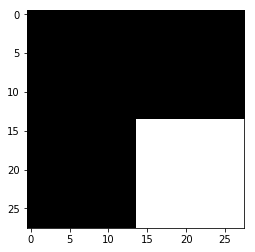

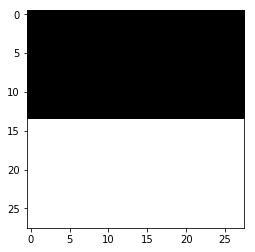

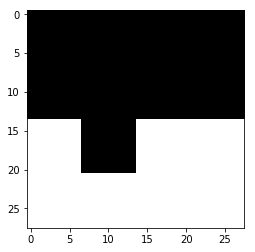

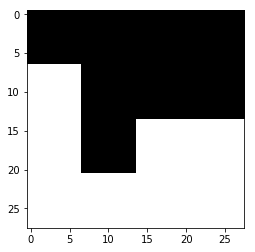

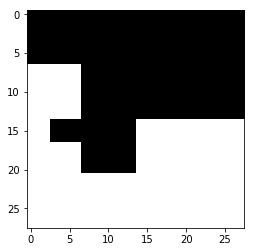

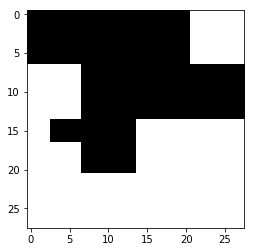

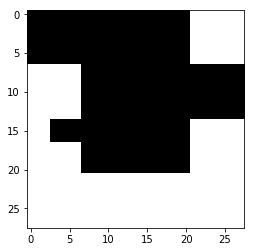

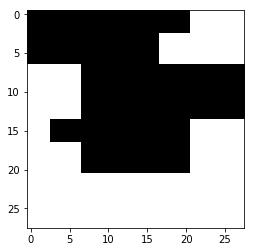

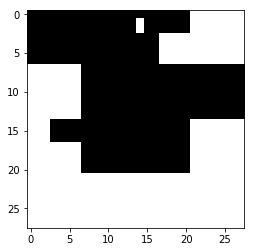

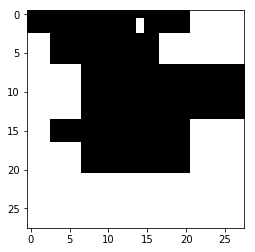

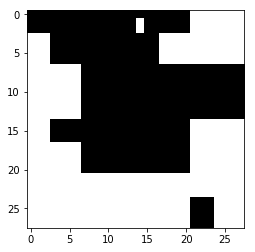

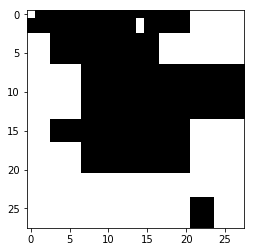

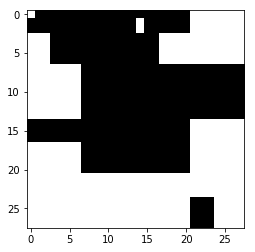

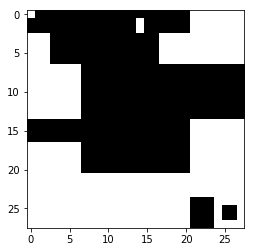

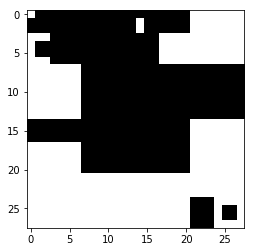

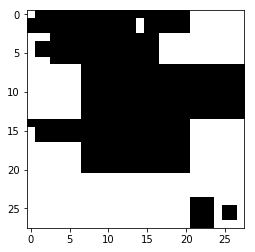

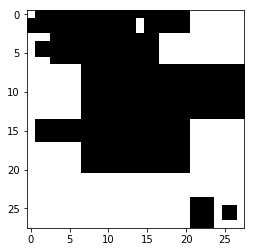

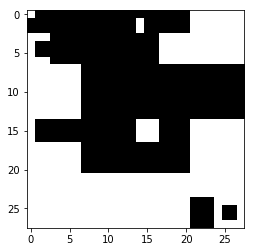

In [14]:
for i in range(18):
    print(policy_wrapper(image)[0])
    game.step(image)
    show(image.data)
    plt.savefig("tmp/anim{}.png".format(i))

In [ ]:
plt.imshow(val_img[5,:,:,0], vmin=0, vmax=1)

In [ ]:
val_labels[:30]